In [1]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import matplotlib.pyplot as plt
import numpy as np
import utils

# Spark session

In [2]:
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("DescriptiveAnalysis")\
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','32G') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

sc=spark.sparkContext

# Read the data 

In [3]:
rdd= sc.textFile('../../Dataset/Google-Playstore-RDD.csv')
header= rdd.first()
rdd= rdd.filter(lambda x: x!=header)
rdd.take(5)

['Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10,15,True,0.0,USD,10M,7.1 and up,Jean Confident Irénée NIYIZIBYOSE,https://beniyizibyose.tk/#/,jean21101999@gmail.com,Feb 26  2020,Feb 26  2020,Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35',
 'Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,5000+,5000,7662,True,0.0,USD,2.9M,5.0 and up,Webserveis,https://webserveis.netlify.app/,webserveis@gmail.com,May 21  2020,May 06  2021,Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35',
 'Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50,58,True,0.0,USD,3.7M,4.0.3 and up,Cabin Crew,,vnacrewit@gmail.com,Aug 9  2019,Aug 19  2019,Everyone,https://www.vietnamairlines.com/vn/en/terms-and-conditions/privacy-policy,False,False,False,2021-06-15 20:19:35',
 'Smart City Trichy Public Service Vehicles 17UCS548,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10,19,True,0.0,USD,1.8M,4.0.3 and up,Climate Sm

In [4]:
#App Name=0
#App Id=1
#Category=2
#Rating=3
#Rating Count=4
#Installs=5
#Minimum Installs=6
#Maximum Installs=7
#Free=8
#Price=9
#Currency=10
#Size=11
#Minimum Android=12
#Developer Id=13
#Developer Website=14
#Developer Email=15
#Released=16
#Last Updated=17
#Content Rating=18
#Privacy Policy=19
#Ad Supported=20
#In App Purchases=21
#Editors Choice=22
#Scraped Time=23

# Analysis points
1. Avg/ Max price and count for each category
2. Max No. of Installs for each category
3. Developed apps per developer
4. Ratings
5. Highest rated Category
6. Highest rated developers (Need insight)
7. #(free/paid) apps in each category
8. Categories of paid apps based on the rating
9. How can people's categories (Everyone/Teen/Adults) affect rating and #installs?
10. Paid Apps based on max rating and Installs
11. Free Apps based on max rating and Installs
12. Avg Installations/ Free-Paid Apps (incomplete)
13. Average app size for each category (incomplete)

# Avg Installations/ Free-Paid Apps

In [5]:
# total_apps= rdd.count()
# free_apps= rdd.filter(lambda x: x.split(',')[8] == 'True').count()
# paid_apps= rdd.filter(lambda x: x.split(',')[8] == 'False').count()

# print(f'Number of Free apps: {free_apps}')
# print(f'Number of Paid apps: {paid_apps}')
# print(f'Total Number of apps: {total_apps}')

In [106]:
# def avg_installs(x):
#     max_installations = x.split(',')[7]
#     min_installations= x.split(',')[6]

#     if x.split(',')[8] == 'True': return ('Free',(max_installations,min_installations))
#     else:                         return ('Paid',(max_installations,min_installations))

# avg_installs_paid = rdd.filter(lambda x:x!='')\
#                 .map(avg_installs)\
#                 .mapValues(lambda x: np.ceil((int(x[0])+int(x[1]))/2))\
#                 .mapValues(lambda x: int(x))\
#                 .reduceByKey(lambda x, y: x + y)\
#                 # .map(lambda x: (x[0], x[1] / free_apps if x[0] == 'Free' else x[1] / paid_apps))
                
# avg_installs_paid.take(2)

# Avg/ Max price and count for each category

In [7]:
#1. we map each row to a tuple of (category, price)
#2. we map each value to a tuple of (price, 0, price) --> (sum of price, count of each category, max price) 
#3. we aggregate by key, summing up the values of each category, 
#   counting the number of each category, and getting the max price of each category
#4. we map each value to a tuple of (avg price, count of each category, max price)
#5. we map each row to a tuple of (category, (count of each category, avg price, max price))

price = rdd.filter(lambda x: x.split(',')[2] != '' and x.split(',')[9]!='') \
        .map(lambda x: (x.split(',')[2], x.split(',')[9])) \
        .mapValues(lambda x: (float(x), 0, float(x))) \
        .aggregateByKey((0.0, 0, 0), 
                         lambda acc, value: (acc[0] + value[0], acc[1] + 1, max(acc[2], value[0])), # addOp then combOp
                         lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1], max(acc1[2], acc2[2]))) \
        .mapValues(lambda x: (x[0] / x[1], x[1], x[2])) \
        .map(lambda x: (x[0], ( x[1][1], x[1][0], x[1][2])))
        
        


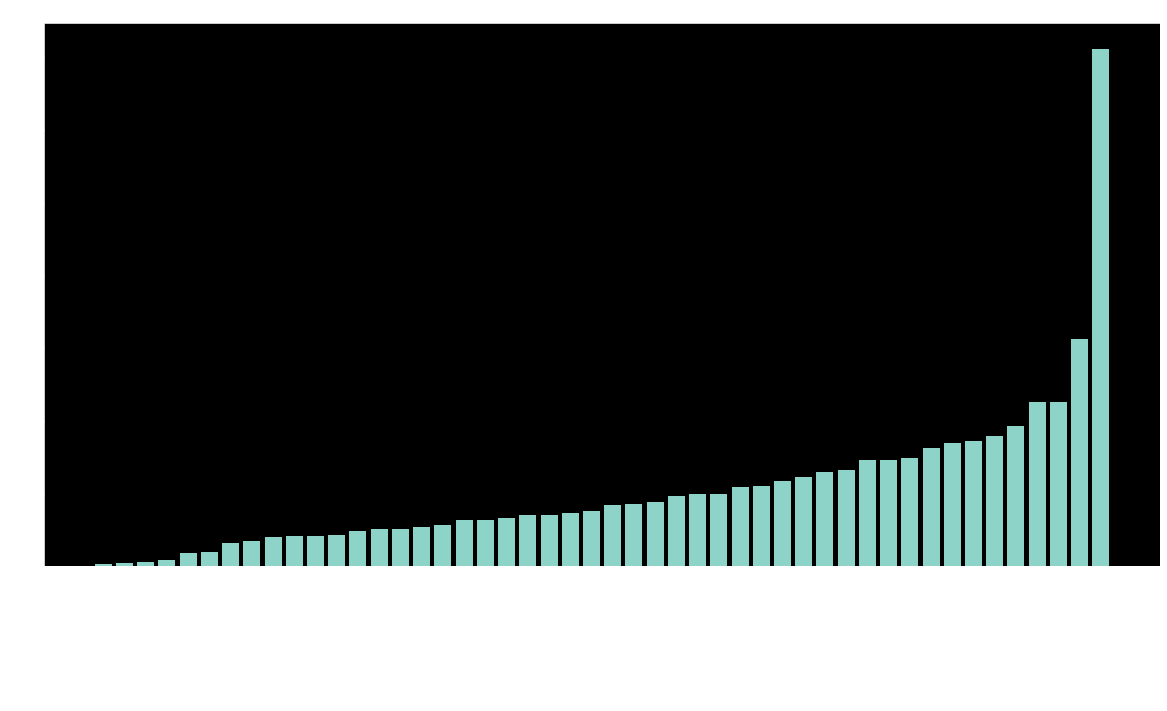

In [8]:
sorted_by_avg= price.sortBy(lambda x: x[1][1], ascending=True)

price_list = sorted_by_avg.map(lambda x: x[1][1]).collect()
category_list = sorted_by_avg.map(lambda x: x[0]).collect()

utils.plots(category_list, price_list, "Category", "Average Price",\
             "Category vs Average Price", "dark_background")


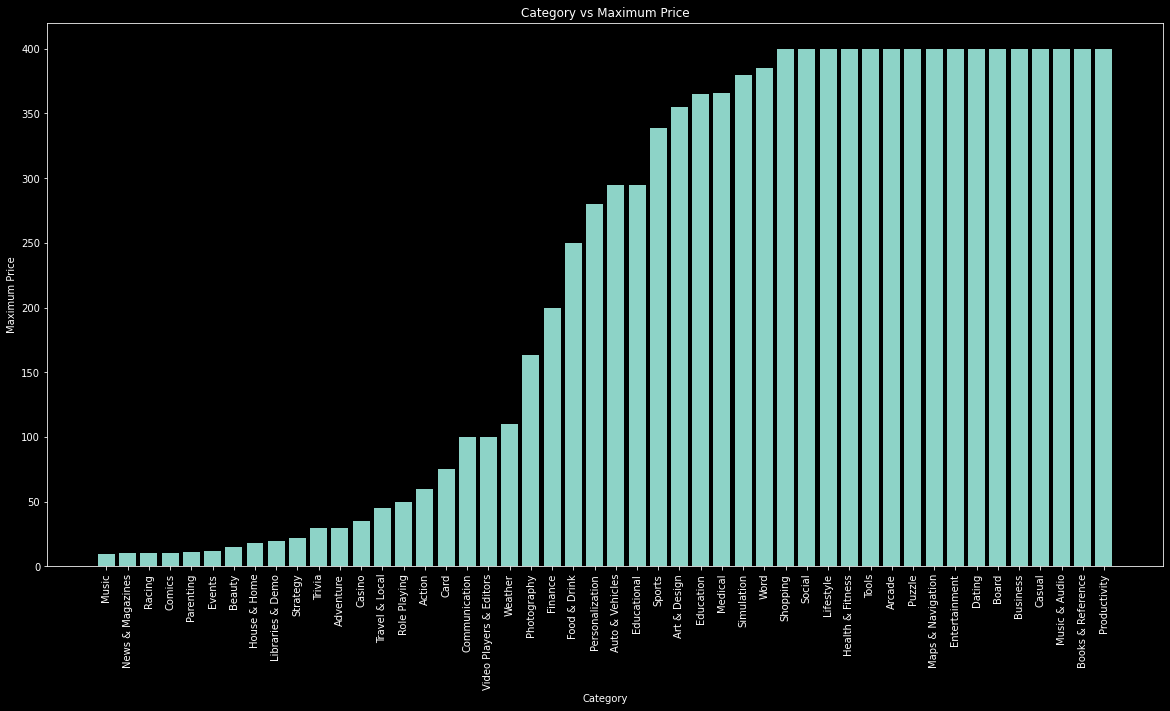

In [9]:
sorted_by_max= price.sortBy(lambda x: x[1][2], ascending=True) 

price_list = sorted_by_max.map(lambda x: x[1][2]).collect()
category_list = sorted_by_max.map(lambda x: x[0]).collect()

utils.plots(category_list, price_list, "Category", "Maximum Price", "Category vs Maximum Price", "dark_background")

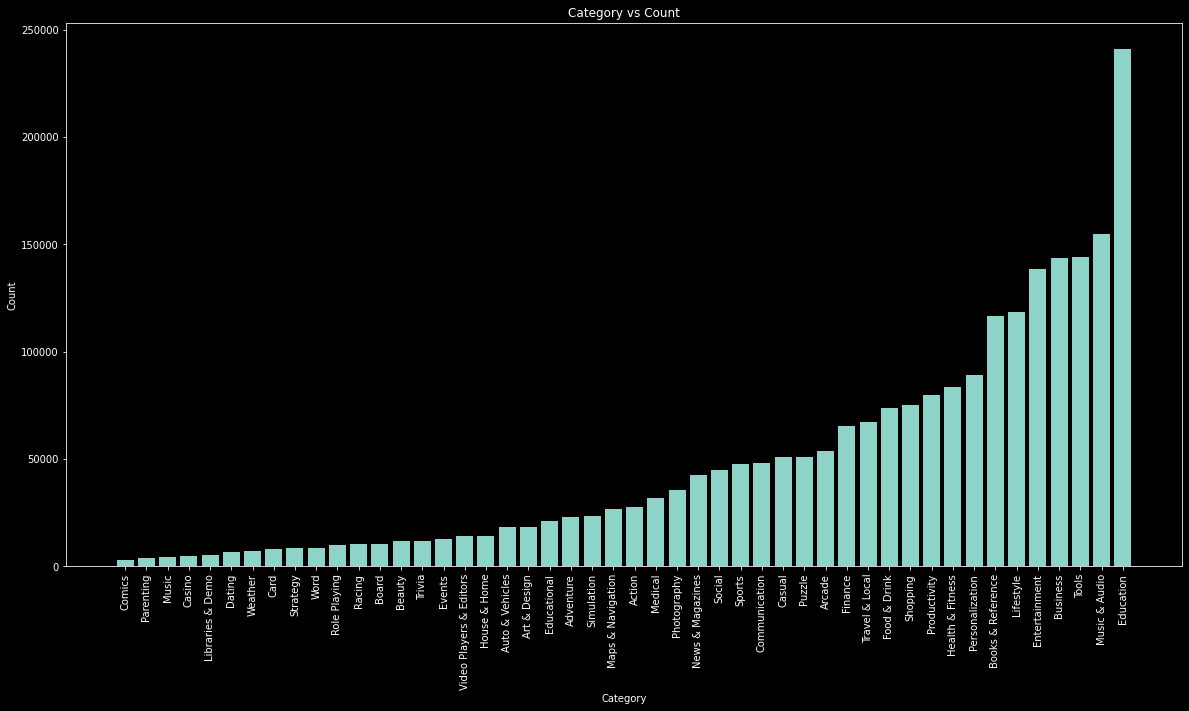

In [10]:
sorted_by_count= price.sortBy(lambda x: x[1][0], ascending=True) 

count_list = sorted_by_count.map(lambda x: x[1][0]).collect()
category_list = sorted_by_count.map(lambda x: x[0]).collect()

utils.plots(category_list, count_list, "Category", "Count", "Category vs Count", "dark_background")

# Max No. of Installs for each category

In [11]:
# max installs= x[7], category= x[2]

max_installs_categ= rdd.filter(lambda x:x.split(',')[2]!='' and x.split(',')[7]!='')\
            .map(lambda x: (x.split(',')[2], x.split(',')[7]))\
            .mapValues(lambda x: int(x))\
            .reduceByKey(lambda x,y:(x+y))\
            .sortBy(lambda x: x[1], ascending=False)


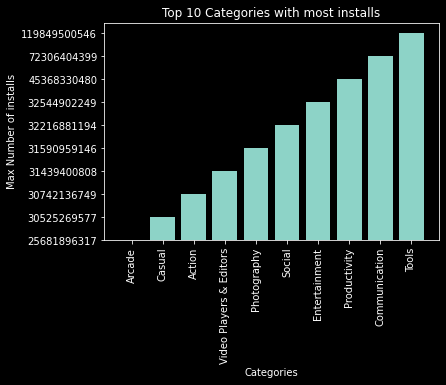

In [12]:
# plot the top 10 categories with most installs
top_10_categ= max_installs_categ.take(10)
top_10_categ= np.array(top_10_categ)
top_10_categ= np.flip(top_10_categ, axis=0)

utils.plots(top_10_categ[:,0], top_10_categ[:,1], "Category", "Max Number of installs",\
             "Top 10 Categories with most installs", "dark_background")


# Average app size for each category

In [111]:
# # size= 11, category= 2
# def convert_to_bytes(size_str):
#     suffixes = {'G': 1000000000, 'M': 1000000, 'k': 1000}
#     for suffix, multiplier in suffixes.items():
#         if suffix in size_str:
#             return float(size_str[:-1]) * multiplier
#     return float(size_str)

# size_rdd = rdd.filter(lambda x: x.split(',')[11]!='Varies with device' and x.split(',')[11]!='') \
#             .map(lambda x: (x.split(',')[2], convert_to_bytes(x.split(',')[11]))) \
#             .mapValues(lambda x: (x,1)) \
#             # .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])) \
#             # .mapValues(lambda x: x[0]/x[1])

# size_rdd.take(50)

# Developed apps per developer

In [14]:
developer_apps= rdd.filter(lambda x:x.split(',')[13]!='')\
                .map(lambda x: (x.split(',')[13], 1))\
                .reduceByKey(lambda x,y:(x+y))\
                .sortBy(lambda x: x[1], ascending=False)

top_developer_apps= np.array(developer_apps.collect())

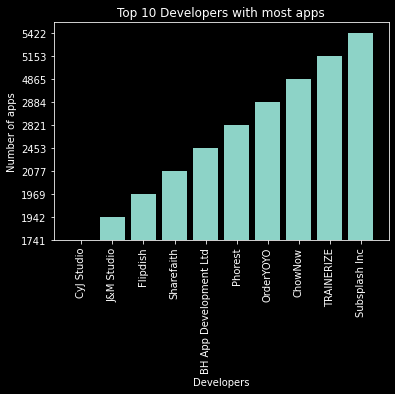

In [15]:
#plot the top 10 developers with most apps 
top_10_developers= top_developer_apps[:10]
top_10_developers= np.array(top_10_developers)
top_10_developers= np.flip(top_10_developers, axis=0)

utils.plots(top_10_developers[:,0], top_10_developers[:,1], "Developer",\
            "Number of apps", "Top 10 Developers with most apps", "dark_background")

# Ratings

In [16]:
ratings= rdd.filter(lambda x: x.split(',')[3] != '')\
        .map(lambda x: (int(np.floor(float(x.split(',')[3]))), 1))\
        .reduceByKey(lambda x,y:(x+y))

ratings_arr= np.array(ratings.collect())

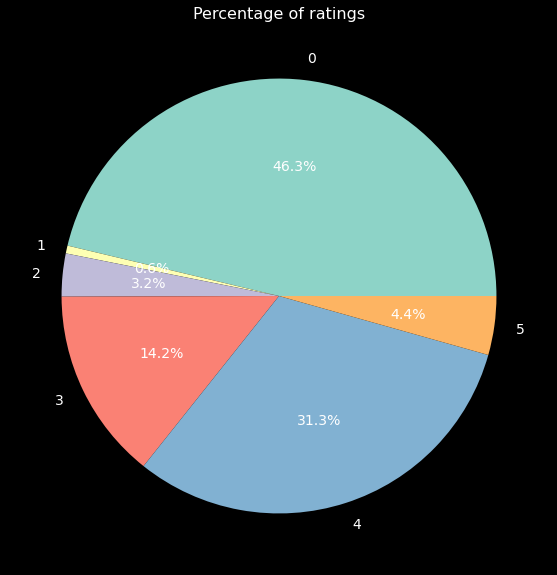

'\nThis shows that most of the users do not rate the apps, and when they do their ratings are usually between 4-5.\n'

In [36]:
utils.pie_plots(ratings_arr[:,1],ratings_arr[:,0],'Percentage of ratings', "dark_background")

'''
This shows that most of the users do not rate the apps, and when they do their ratings are usually between 4-5.
'''

# Highest rated Category


In [18]:
categ_rate= rdd.filter(lambda x: x.split(',')[2] != '' and x.split(',')[3] != '')\
        .map(lambda x: (x.split(',')[2], x.split(',')[3]))\
        .mapValues(lambda x: (float(x), 1))\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .mapValues(lambda x: x[0]/x[1])\
        .sortBy(lambda x: x[1], ascending=True)

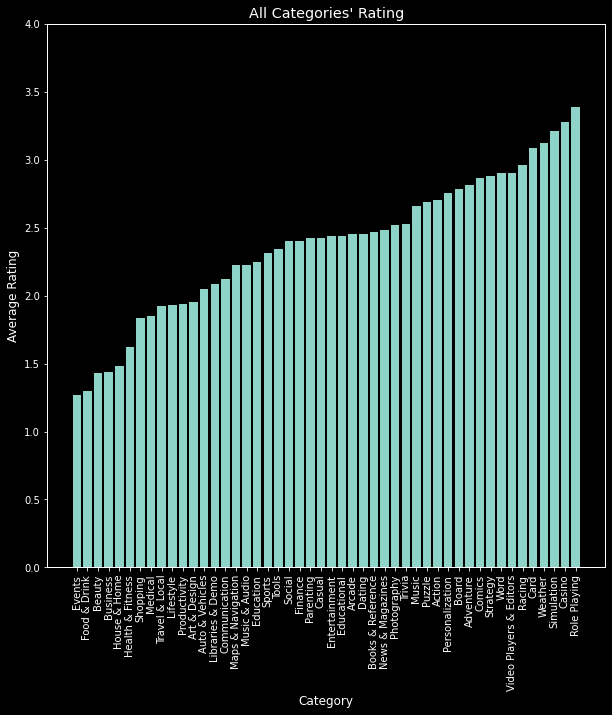

In [19]:
categories = [x[0] for x in categ_rate.collect()]
ratings = [x[1] for x in categ_rate.collect()]

utils.plots(categories, ratings, "Category", "Average Rating",\
            "Category vs Average Rating", "dark_background", y_limit=True)


# Highest rated developers

In [20]:
developer_rates= rdd.filter(lambda x: x.split(',')[13] != '' and x.split(',')[3] != '')\
        .map(lambda x: (x.split(',')[13], x.split(',')[3]))\
        .mapValues(lambda x: (float(x), 1))\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .mapValues(lambda x: x[0]/x[1])\
        .sortBy(lambda x: x[1], ascending=False)

In [21]:
#TODO: Need a suitable insight for this

dev_rates= np.array(developer_rates.collect())

# #(free/paid) apps in each category

In [22]:
#Category=2
#Free=8
#key= category, value= (#free apps in that category, #paid apps in that category)

categ_payment= rdd.filter(lambda x: x.split(',')[2] != '' and x.split(',')[8] != '')\
        .map(lambda x: (x.split(',')[2], x.split(',')[8]))\
        .mapValues(lambda x: (1, 0) if x == 'True' else (0, 1))\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))

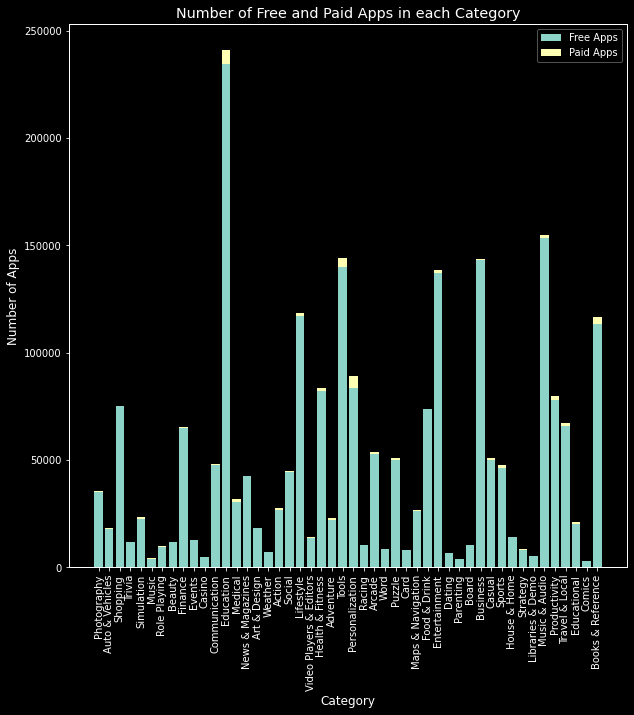

In [40]:
categories = [x[0] for x in categ_payment.collect()]
free_apps = [x[1][0] for x in categ_payment.collect()]
paid_apps = [x[1][1] for x in categ_payment.collect()]

utils.plots(categories,free_apps,'Category','Number of Apps',\
            'Number of Free and Paid Apps in each Category',\
            stacked=True, y2=paid_apps, label2='Paid Apps')


# Categories of paid apps based on the rating

In [24]:
# rating=3 : float
# Free=8 : True/False 
# categ=2 : str

paid_apps_rate_categ=rdd.filter(lambda x:  x.split(',')[3] != '' and x.split(',')[8] =='False' and x.split(',')[2] != '')\
                    .map(lambda x: (x.split(',')[2], (float(x.split(',')[3]),1)))\
                    .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
                    .mapValues(lambda x: x[0]/x[1])\
                    .sortBy(lambda x: x[1])

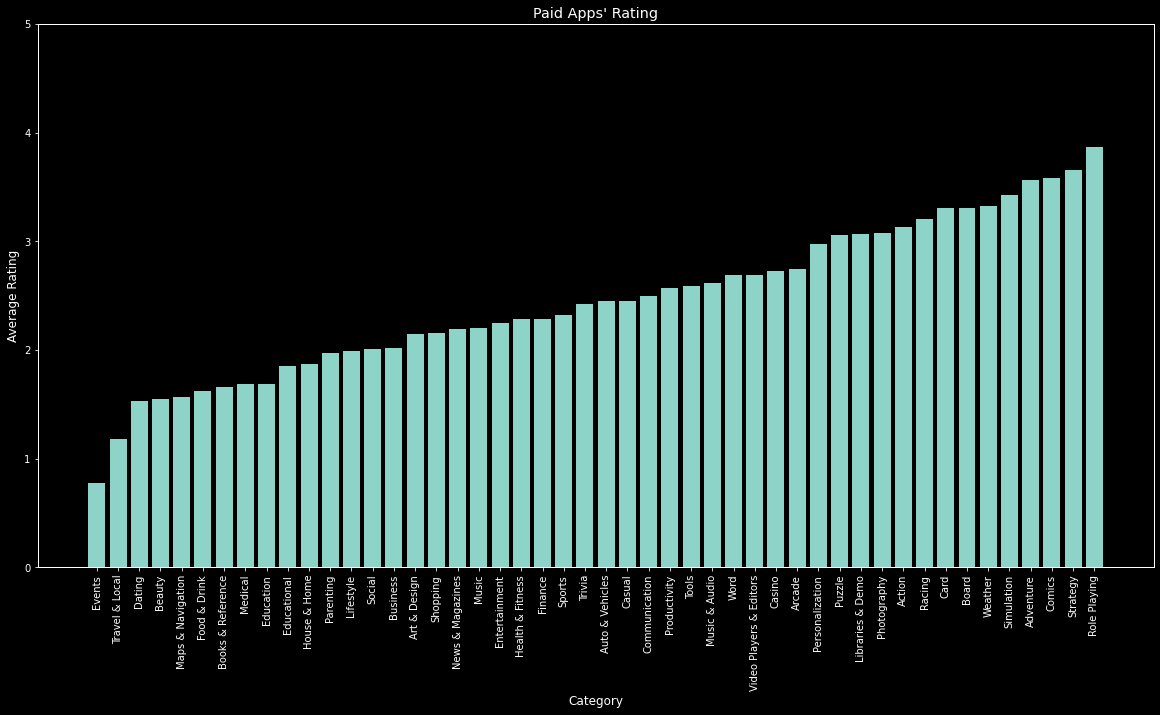

In [39]:
categories = [x[0] for x in paid_apps_rate_categ.collect()]
ratings = [x[1] for x in paid_apps_rate_categ.collect()]


utils.plots(categories, ratings, "Category", "Average Rating", "Paid Apps' Rating",\
             "dark_background", y_limit=True)

# How can people's categories (Everyone/Teen/Adults) affect rating and #installs?

In [26]:
#rating count= 4 : int
#max installs=7 : int
#content rating=18 : str 
# key= content rating, value= (max installs, rating count) 

categ_installs_rate= rdd.filter(lambda x: x.split(',')[4] != '' and x.split(',')[7] != '' and x.split(',')[18] != '')\
                    .map(lambda x: (x.split(',')[18], (int(x.split(',')[7]), int(float(x.split(',')[4])))))\
                    .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
                    .sortBy(lambda x: x[1], ascending=True)

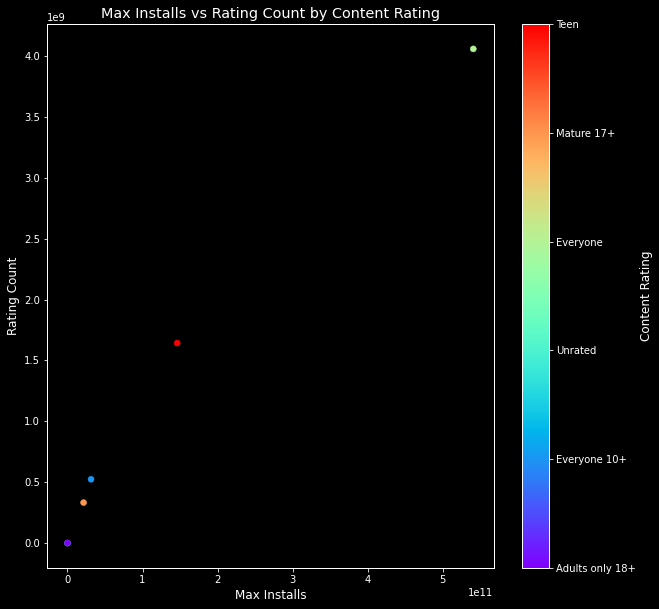

'\nEveryone then teens are more engaged with the apps, and they are more likely to rate the apps.\n'

In [27]:
content_rating = [x[0] for x in categ_installs_rate.collect()]
max_installs = [x[1][0] for x in categ_installs_rate.collect()]
rating_count = [x[1][1] for x in categ_installs_rate.collect()]

x = max_installs
y = rating_count
hue = content_rating


utils.scatter_plot_colorbar(max_installs,rating_count,content_rating,\
                            'Max Installs','Rating Count','Content Rating',\
                            'Max Installs vs Rating Count by Content Rating', 'dark_background')

'''
Everyone then teens are more engaged with the apps, and they are more likely to rate the apps.
'''

# Paid Apps based on max rating and Installs

In [47]:
# filter based on paid apps
# min installs=6 : int
# rating=3 : float
# Free=8 : True/False 
# app_name=0 : str
# key= app name, value= (rating, installs)

paid_apps_rate_installs = rdd.filter(lambda x: x.split(',')[6] != '' and x.split(',')[3] != '' and x.split(',')[8] =='False' and x.split(',')[0] != '') \
                    .map(lambda x: (x.split(',')[0], (float(x.split(',')[3]), int(float(x.split(',')[6]))))) \
                    .mapValues(lambda x: (x[0], x[1])) \
                    .reduceByKey(lambda x,y: (max(x[0], y[0]), x[1]+x[1])) \
                    .filter(lambda x: x[1][1] > 500000) \
                    .sortBy(lambda x: (-x[1][0], x[1][1])) \
                    .mapValues(lambda x: x[0])


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


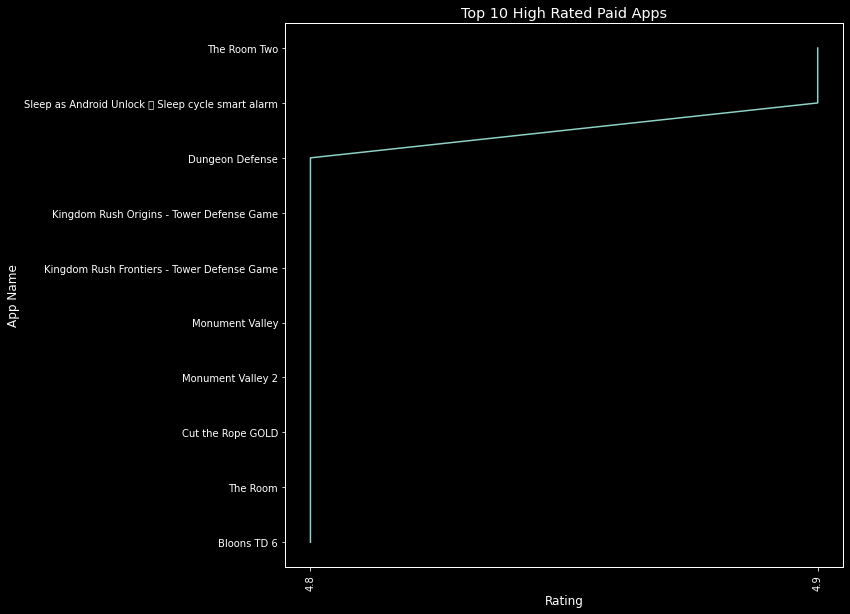

In [48]:
high_rated_paid_apps= np.array(paid_apps_rate_installs.take(10))
high_rated_paid_apps= high_rated_paid_apps[::-1]

app_name = [x[0] for x in high_rated_paid_apps]
rating = [x[1] for x in high_rated_paid_apps]

utils.plots(rating, app_name, "Rating", "App Name", "Top 10 High Rated Paid Apps", "dark_background",line_plot=True)


# Free Apps based with highest rating and Installs

In [49]:
free_apps_rate_installs=rdd.filter(lambda x: x.split(',')[6] != '' and x.split(',')[3] != '' and x.split(',')[8] =='True' and x.split(',')[0] != '') \
                    .map(lambda x: (x.split(',')[0], (float(x.split(',')[3]), int(float(x.split(',')[6]))))) \
                    .mapValues(lambda x: (x[0], x[1])) \
                    .reduceByKey(lambda x,y: (max(x[0], y[0]), x[1]+x[1])) \
                    .filter(lambda x: x[1][1] > 500000) \
                    .sortBy(lambda x: (-x[1][0], x[1][1])) \
                    .mapValues(lambda x: x[0])


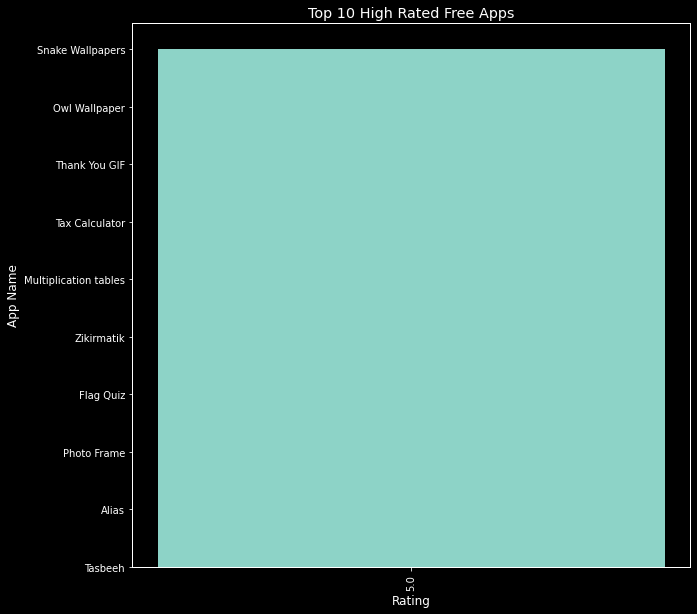

In [50]:
high_rated_free_apps= np.array(free_apps_rate_installs.take(10))
high_rated_free_apps= high_rated_free_apps[::-1]

app_name = [x[0] for x in high_rated_free_apps]
rating = [x[1] for x in high_rated_free_apps]

utils.plots(rating, app_name, "Rating", "App Name", "Top 10 High Rated Free Apps", "dark_background",line_plot=True)